In [1]:
import ROOT
from ROOT import TFile
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import copy
import pandas as pd 
import time
import root_pandas as rpd
from root_pandas import read_root

#mpl.rcParams['figure.figsize'] = 6.2,3.5
#mpl.rcParams['axes.labelsize'] = 17
#mpl.rcParams['lines.linewidth'] = 3
#mpl.rcParams['lines.markersize'] = 6
#mpl.rcParams['legend.fontsize']= 15



mpl.rcParams.update({'font.size': 18})
mpl.rcParams.update({'legend.fontsize': 20})
mpl.rcParams.update({'xtick.labelsize': 18}) 
mpl.rcParams.update({'ytick.labelsize': 18}) 
mpl.rcParams.update({'text.usetex' : False})

Welcome to JupyROOT 6.15/01


In [2]:
def applyCut(inputDataframe, cut, text=None):
    nbeforecut = inputDataframe.shape[0]
    if nbeforecut>0:
        cutDataframe = inputDataframe.query(cut)
        if text:
            print text, cutDataframe.shape[0], ' (%2.2f '%(100.0*cutDataframe.shape[0]/nbeforecut), '%)'
    return cutDataframe
def applyHadronCuts(fullDataframe,name='default',isMC=False): 
    dataframe = fullDataframe
    print 'Entries before cut ', dataframe.shape[0]
    dataframe.eval('inelasticity = Nu/5.014', inplace=True)
    dataframe.eval('E = z*Nu', inplace=True)
    dataframe.eval('P = sqrt(E*E-0.1396*0.1396)', inplace=True)
    dataframe.eval('T = E-0.1396', inplace=True)
    dataframe.eval('pt2 = pt*pt', inplace=True)

    #dataframe = applyCut(dataframe, 'Q2>1.0 and Q2<1.25', ' 1.0 <Q2<1.25 :')
    #dataframe = applyCut(dataframe, 'Nu>3.5 and Nu<4.0',  ' 3.5 <Nu<4.0')
    dataframe = applyCut(dataframe, 'P <2.5 ', 'P<2.5 ')
    dataframe = applyCut(dataframe, 'P >0.2 ', 'P>0.2 ')

    dataframe = applyCut(dataframe, 'inelasticity<0.85','inelasticity < 0.85')
    return dataframe

def applyElectronCuts(fullDataframe,name='default',isMC=False): 
    dataframe = fullDataframe
    print 'Entries before cut ', dataframe.shape[0]
    dataframe.eval('inelasticity = Nu/5.014', inplace=True)
    #dataframe = applyCut(dataframe, 'Q2>1.0 and Q2<1.25', ' 1.0 <Q2<1.25 :')
    #dataframe = applyCut(dataframe, 'Nu>3.5 and Nu<4.0',  ' 3.5 <Nu<4.0')
    dataframe = applyCut(dataframe, 'inelasticity<0.85','inelasticity < 0.85')
    return dataframe





In [3]:
def getRatio(df_A,df_D,df_electron_A,df_electron_D, variable='z',event_cut='Q2>1.0',hadron_cut = ' and P>0',minz=0.05,maxz=1.0,nbins=9):
    
    
    norm_A = df_electron_A.query(event_cut).shape[0]
    norm_D = df_electron_D.query(event_cut).shape[0]
    print 'Number of electron A', norm_A
    print 'Number of electron D', norm_D
    
    y_A, x_conditional = np.histogram(df_A.query(event_cut+hadron_cut)[variable],bins=np.logspace(np.log10(minz), np.log10(maxz),nbins))
    y_D, x_conditional = np.histogram(df_D.query(event_cut+hadron_cut)[variable],bins=np.logspace(np.log10(minz), np.log10(maxz),nbins))
    x_conditional = (x_conditional[1:] + x_conditional[:-1])/2.0
    err_A = np.true_divide(np.sqrt(y_A),y_A)
    err_D = np.true_divide(np.sqrt(y_D),y_D)
    y_A = np.true_divide(y_A,norm_A)
    y_D = np.true_divide(y_D,norm_D)
    ratio_conditional = np.true_divide(y_A,y_D)
    error_conditional = np.multiply(ratio_conditional, np.sqrt(np.power(err_A,2.0) + np.power(err_D,2.0)))
    
    
    return ratio_conditional,error_conditional,x_conditional

## Get data from Ntuples to dataframes

In [4]:
#this needs to be read in chunks otherwise it uses all memory. (from https://github.com/scikit-hep/root_pandas)
def getdatainChunks(filename,treename):
    dataframe =pd.DataFrame()
    for df in read_root(filename, treename, chunksize=100000) :
        #print df.shape[0]
        dataframe = pd.concat([dataframe,df])
    
    print dataframe.shape[0]
    return dataframe
    

In [5]:
df = {}

## GiBUU 

In [6]:
for target in ['D','C','Fe','Pb']:
    #GiBUU
    print target
    print ' hadron'
    df['GiBUU_%s_hadron'%target]= getdatainChunks('GiBUU_SingleHadron_%s.root'%target, '%s_hadron'%target)
    print ' electron'
    df['GiBUU_%s_electron'%target]= getdatainChunks('GiBUU_SingleHadron_%s.root'%target,'%s_electron'%target)
print df.keys()

D
 hadron
3286867
 electron
2458112
C
 hadron
3726071
 electron
2566117
Fe
 hadron
2795531
 electron
1852429
Pb
 hadron
2803028
 electron
1800379
['GiBUU_Fe_hadron', 'GiBUU_Pb_electron', 'GiBUU_C_hadron', 'GiBUU_Pb_hadron', 'GiBUU_D_hadron', 'GiBUU_Fe_electron', 'GiBUU_D_electron', 'GiBUU_C_electron']


In [7]:
print df.keys()

['GiBUU_Fe_hadron', 'GiBUU_Pb_electron', 'GiBUU_C_hadron', 'GiBUU_Pb_hadron', 'GiBUU_D_hadron', 'GiBUU_Fe_electron', 'GiBUU_D_electron', 'GiBUU_C_electron']


In [8]:
for target in ['D','C','Fe','Pb']:
    print target
    df['GiBUU_%s_electron'%target] = applyElectronCuts(df['GiBUU_%s_electron'%target], isMC=True)
    df['GiBUU_%s_hadron'%target] = applyHadronCuts(df['GiBUU_%s_hadron'%target], isMC=True)
    print ' ' 


D
Entries before cut  2458112
inelasticity < 0.85 2458112  (100.00  %)
Entries before cut  3286867
P<2.5  2993770  (91.08  %)
P>0.2  2706820  (90.42  %)
inelasticity < 0.85 2706820  (100.00  %)
 
C
Entries before cut  2566117
inelasticity < 0.85 2566117  (100.00  %)
Entries before cut  3726071
P<2.5  3477988  (93.34  %)
P>0.2  2879078  (82.78  %)
inelasticity < 0.85 2879078  (100.00  %)
 
Fe
Entries before cut  1852429
inelasticity < 0.85 1852429  (100.00  %)
Entries before cut  2795531
P<2.5  2657242  (95.05  %)
P>0.2  1990598  (74.91  %)
inelasticity < 0.85 1990598  (100.00  %)
 
Pb
Entries before cut  1800379
inelasticity < 0.85 1800379  (100.00  %)
Entries before cut  2803028
P<2.5  2700969  (96.36  %)
P>0.2  1827801  (67.67  %)
inelasticity < 0.85 1827801  (100.00  %)
 


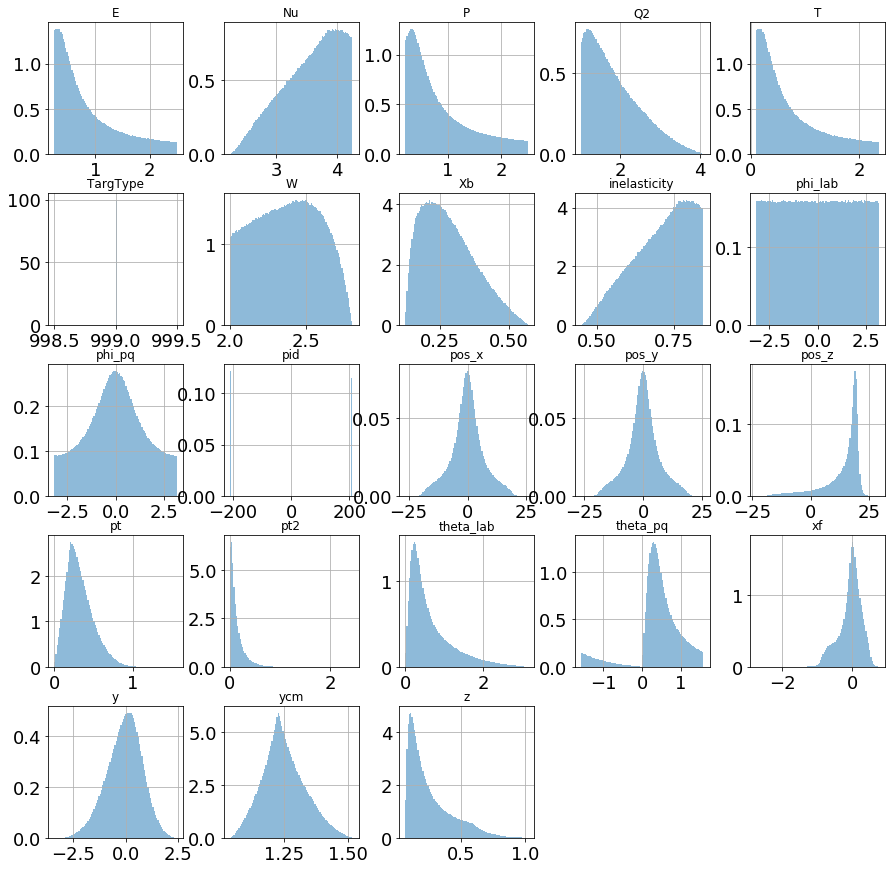

In [9]:
df['GiBUU_D_hadron'].hist(figsize=(15, 15),normed=True,alpha=0.5,bins=100)
plt.show()

## Apply cuts for trigger dataframes

Number of electron A 2566117
Number of electron D 2458112
Number of electron A 1852429
Number of electron D 2458112
Number of electron A 1800379
Number of electron D 2458112


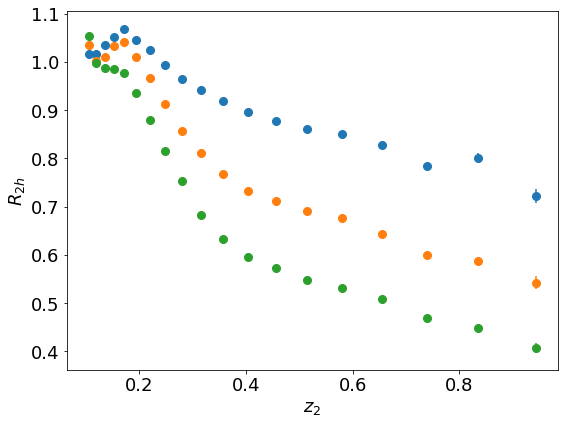

In [10]:
fig = plt.figure(figsize=(8,6))

for target in ['C','Fe','Pb']:
    r, err,x = getRatio(df['GiBUU_%s_hadron'%target], df['GiBUU_D_hadron'], 
                        df['GiBUU_%s_electron'%target], df['GiBUU_D_electron'],
                        minz=0.1,maxz=1.0,nbins=20)
    plt.errorbar(x,r,yerr=err,label='This work,  %s'%target,fmt='o',ms=8)

plt.xlabel('$z_{2}$',fontsize=18)
plt.ylabel('$R_{2h}$',fontsize=18)


plt.tight_layout()
plt.savefig('Rh.png')
#plt.xlim([0.05,0.5])

#plt.xscale('log')
#plt.savefig('ComparisonWithHermes_Log.png')

plt.show()

## Rh vs z for both pi+ and pi- 

Number of electron A 2566117
Number of electron D 2458112
Number of electron A 2566117
Number of electron D 2458112
Number of electron A 1852429
Number of electron D 2458112
Number of electron A 1852429
Number of electron D 2458112
Number of electron A 1800379
Number of electron D 2458112
Number of electron A 1800379
Number of electron D 2458112


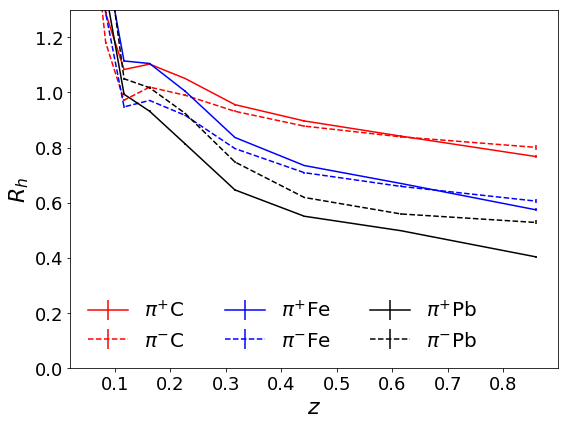

In [11]:
fig = plt.figure(figsize=(8,6))


colors = {}
colors['C'] = 'red'
colors['Fe'] = 'blue'
colors['Pb']= 'black'

for target in ['C','Fe','Pb']:
    r, err,x = getRatio(df['GiBUU_%s_hadron'%target].query('pid==211'), df['GiBUU_D_hadron'].query('pid==211'), 
                        df['GiBUU_%s_electron'%target], df['GiBUU_D_electron'],
                        minz=0.05,maxz=1.0,nbins=10)
    
    plt.errorbar(x,r,yerr=err,label=r'$\pi^{+}$'+'%s'%target,fmt='-',ms=8,color=colors[target])
    
    
    r, err,x = getRatio(df['GiBUU_%s_hadron'%target].query('pid==-211'), df['GiBUU_D_hadron'].query('pid==-211'), 
                        df['GiBUU_%s_electron'%target], df['GiBUU_D_electron'],
                        minz=0.05,maxz=1.0,nbins=10)
    
    plt.errorbar(x,r,yerr=err,label=r'$\pi^{-}$'+'%s'%target,fmt='-',ms=8,ls='--',color=colors[target])
    

plt.xlabel('$z$',fontsize=22)
plt.ylabel('$R_{h}$',fontsize=22)
plt.legend(loc='best',ncol=3,frameon=False)
plt.ylim([0.0,1.3])

plt.tight_layout()
plt.savefig('Rh.png')

# momentum

Number of electron A 2566117
Number of electron D 2458112
Number of electron A 2566117
Number of electron D 2458112
Number of electron A 1852429
Number of electron D 2458112
Number of electron A 1852429
Number of electron D 2458112
Number of electron A 1800379
Number of electron D 2458112
Number of electron A 1800379
Number of electron D 2458112


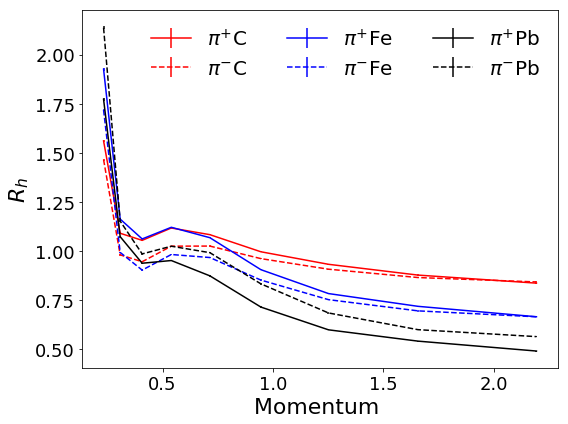

In [12]:
fig = plt.figure(figsize=(8,6))


colors = {}
colors['C'] = 'red'
colors['Fe'] = 'blue'
colors['Pb']= 'black'

for target in ['C','Fe','Pb']:
    r, err,x = getRatio(df['GiBUU_%s_hadron'%target].query('pid==211'), df['GiBUU_D_hadron'].query('pid==211'), 
                        df['GiBUU_%s_electron'%target], df['GiBUU_D_electron'],
                        minz=0.2,maxz=2.5,nbins=10,variable='P')
    
    plt.errorbar(x,r,yerr=err,label=r'$\pi^{+}$'+'%s'%target,fmt='-',ms=8,color=colors[target])
    
    
    r, err,x = getRatio(df['GiBUU_%s_hadron'%target].query('pid==-211'), df['GiBUU_D_hadron'].query('pid==-211'), 
                        df['GiBUU_%s_electron'%target], df['GiBUU_D_electron'],
                        minz=0.2,maxz=2.5,nbins=10,variable='P')
    
    plt.errorbar(x,r,yerr=err,label=r'$\pi^{-}$'+'%s'%target,fmt='-',ms=8,ls='--',color=colors[target])
    

plt.xlabel('Momentum ',fontsize=22)
plt.ylabel('$R_{h}$',fontsize=22)
plt.legend(loc='best',ncol=3,frameon=False)
#plt.ylim([0.0,1.3])

plt.tight_layout()
plt.savefig('Rh_mmentum.png')

## Transverse momentum

Number of electron A 2566117
Number of electron D 2458112
Number of electron A 2566117
Number of electron D 2458112
Number of electron A 1852429
Number of electron D 2458112
Number of electron A 1852429
Number of electron D 2458112
Number of electron A 1800379
Number of electron D 2458112
Number of electron A 1800379
Number of electron D 2458112


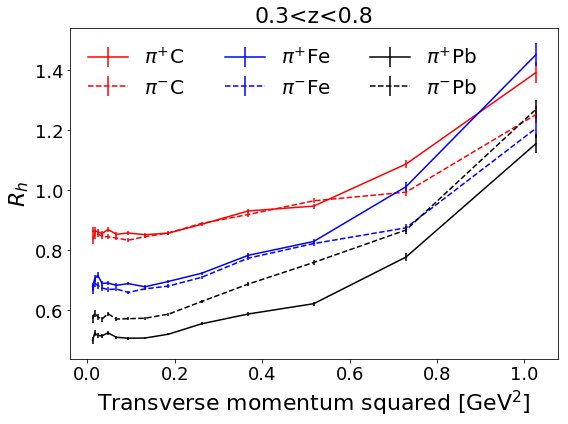

In [30]:
fig = plt.figure(figsize=(8,6))


colors = {}
colors['C'] = 'red'
colors['Fe'] = 'blue'
colors['Pb']= 'black'

for target in ['C','Fe','Pb']:
    r, err,x = getRatio(df['GiBUU_%s_hadron'%target].query('pid==211 and z>0.3and z<0.8'), df['GiBUU_D_hadron'].query('pid==211 and z>0.3 and z<0.8'), 
                        df['GiBUU_%s_electron'%target], df['GiBUU_D_electron'],
                        minz=0.01,maxz=1.2,nbins=15,variable='pt2')
    
    plt.errorbar(x,r,yerr=err,label=r'$\pi^{+}$'+'%s'%target,fmt='-',ms=8,color=colors[target])
    
    r, err,x = getRatio(df['GiBUU_%s_hadron'%target].query('pid==-211 and z>0.3 and z<0.8'), df['GiBUU_D_hadron'].query('pid==-211 and z>0.3 and z<0.8'), 
                        df['GiBUU_%s_electron'%target], df['GiBUU_D_electron'],
                        minz=0.01,maxz=1.2,nbins=15,variable='pt2')
    
    plt.errorbar(x,r,yerr=err,label=r'$\pi^{-}$'+'%s'%target,fmt='-',ms=8,ls='--',color=colors[target])
    

    #r, err,x = getRatio(df['GiBUU_%s_hadron'%target].query('pid==-211'), df['GiBUU_D_hadron'].query('pid==-211 and P>0.2'), 
    #                    df['GiBUU_%s_electron'%target], df['GiBUU_D_electron'],
    #                    minz=0.1,maxz=2.5,nbins=10,variable='T')
    
    #plt.errorbar(x,r,yerr=err,label=r'$\pi^{-}$'+'%s'%target,fmt='-',ms=8,ls='--',color=colors[target])
    

plt.title('0.3<z<0.8',fontsize=22)
plt.xlabel('Transverse momentum squared [GeV$^{2}$]',fontsize=22)
plt.ylabel('$R_{h}$',fontsize=22)
plt.legend(loc='best',ncol=3,frameon=False)
#plt.ylim([0.0,1.3])

#plt.xscale('log')
plt.tight_layout()
plt.savefig('Rh_pt2.png')

0.019607413264676132
0.028854875331232627
0.02700998236622068
0.00863875831759256
0.017359737613355936
0.01933203293701452


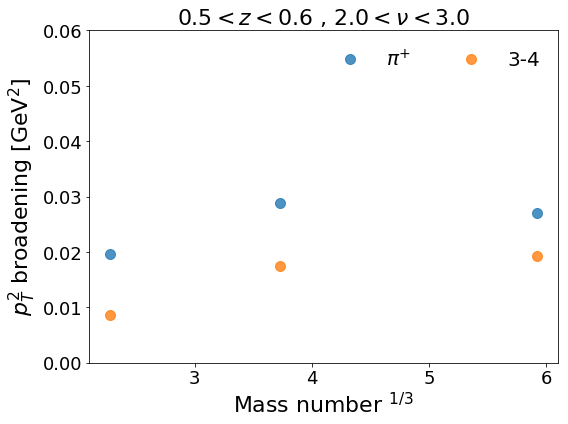

In [60]:
broadening_pip = []
mass_number = [12,52,208]
mass_number_cubicroot = [2.28, 3.73,5.92]
fig = plt.figure(figsize=(8,6))
broadening_pim= []

selection = 'z>0.5 and z<0.6 and Nu<3 and Nu>2 and Q2<2 and Q2>1'

ref = df['GiBUU_D_hadron'].query('pid==211 and '+selection)['pt2'].mean()
for target in ['C','Fe','Pb']:
    A = df['GiBUU_%s_hadron'%target].query('pid==211 and '+selection)['pt2'].mean()
    print A-ref
    #print A
    broadening_pip.append(A-ref)

plt.plot(mass_number_cubicroot,broadening_pip,'o',ms=10,alpha=0.8,label='$\pi^{+}$')


selection = 'z>0.5 and z<0.6 and Nu<4 and Nu>3 and Q2<2 and Q2>1'
broadening_pip= []
ref = df['GiBUU_D_hadron'].query('pid==211 and '+selection)['pt2'].mean()
for target in ['C','Fe','Pb']:
    A = df['GiBUU_%s_hadron'%target].query('pid==211 and '+selection)['pt2'].mean()
    print A-ref
    #print A
    broadening_pip.append(A-ref)

plt.plot(mass_number_cubicroot,broadening_pip,'o',ms=10,alpha=0.8,label='3-4')


    
#print broadening
#ref = df['GiBUU_D_hadron'].query('pid==-211 and '+selection)['pt2'].mean()
#for target in ['C','Fe','Pb']:
#    A = df['GiBUU_%s_hadron'%target].query('pid==-211 and '+selection)['pt2'].mean()
#    print A-ref
#    broadening_pim.append(A-ref)
    
#plt.plot(mass_number_cubicroot,broadening_pim,'o',ms=10,alpha=0.8,label='$\pi^{-}$')


plt.title(r'$0.5<z<0.6$ , $2.0<\nu<3.0$',fontsize=22)
plt.ylabel('$p_{T}^{2}$ broadening [GeV$^{2}$]',fontsize=22)
plt.xlabel('Mass number $^{1/3}$',fontsize=22)
plt.legend(loc='best',ncol=3,frameon=False)
plt.ylim([0.0,0.06])

#plt.xscale('log')
plt.tight_layout()
plt.savefig('Broadening.png')

## Kinetic energy

In [ ]:
fig = plt.figure(figsize=(8,6))


colors = {}
colors['C'] = 'red'
colors['Fe'] = 'blue'
colors['Pb']= 'black'

for target in ['C','Fe','Pb']:
    r, err,x = getRatio(df['GiBUU_%s_hadron'%target].query('pid==211'), df['GiBUU_D_hadron'].query('pid==211 and P>0.2'), 
                        df['GiBUU_%s_electron'%target], df['GiBUU_D_electron'],
                        minz=0.1,maxz=2.5,nbins=20,variable='T')
    
    plt.errorbar(x,r,yerr=err,label=r'$\pi^{+}$'+'%s'%target,fmt='-',ms=8,color=colors[target])
    
    
    #r, err,x = getRatio(df['GiBUU_%s_hadron'%target].query('pid==-211'), df['GiBUU_D_hadron'].query('pid==-211 and P>0.2'), 
    #                    df['GiBUU_%s_electron'%target], df['GiBUU_D_electron'],
    #                    minz=0.1,maxz=2.5,nbins=10,variable='T')
    
    #plt.errorbar(x,r,yerr=err,label=r'$\pi^{-}$'+'%s'%target,fmt='-',ms=8,ls='--',color=colors[target])
    

plt.xlabel('Kinetic Energy',fontsize=22)
plt.ylabel('$R_{h}$',fontsize=22)
plt.legend(loc='best',ncol=3,frameon=False)
#plt.ylim([0.0,1.3])

plt.xscale('log')
plt.tight_layout()
plt.savefig('Rh_mmentum.png')

In [ ]:
fig = plt.figure(figsize=(8,6))


colors = {}
colors['C'] = 'red'
colors['Fe'] = 'blue'
colors['Pb']= 'black'

minQ2 = 1.85
maxQ2 = 2.40
minNu = 2.2
maxNu = 3.0

event_selection = 'Q2>%2.2f and Q2<%2.2f and Nu>%2.2f and Nu<%2.2f'%(minQ2,maxQ2,minNu,maxNu)
print event_selection

for target in ['C','Fe','Pb']:
    r_pip, err,x = getRatio(df['GiBUU_%s_hadron'%target].query('pid==211'), df['GiBUU_D_hadron'].query('pid==211'), 
                        df['GiBUU_%s_electron'%target], df['GiBUU_D_electron'], event_cut = event_selection,
                        minz=0.05,maxz=1.0,nbins=10)
    
    plt.errorbar(x,r_pip,yerr=err,label=r'$\pi^{+}$'+'%s'%target,fmt='-',ms=8,color=colors[target])
    
    
    r_pim, err,x = getRatio(df['GiBUU_%s_hadron'%target].query('pid==-211'), df['GiBUU_D_hadron'].query('pid==-211'), 
                        df['GiBUU_%s_electron'%target], df['GiBUU_D_electron'], event_cut = event_selection,
                        minz=0.05,maxz=1.0,nbins=10)
    
    plt.errorbar(x,r_pim,yerr=err,label=r'$\pi^{-}$'+'%s'%target,fmt='-',ms=8,ls='--',color=colors[target])
    
    print 'pi+', r_pip
    print 'pi-', r_pim
    print np.true_divide(r_pip,r_pim)

plt.title(r'%2.2f$<Q^{2}<$%2.2f GeV$^{2}$, %2.2f$<\nu<$%2.2f GeV'%(minQ2,maxQ2,minNu,maxNu))
    
plt.xlabel('$z$',fontsize=22)
plt.ylabel('$R_{h}$',fontsize=22)
plt.legend(loc='best',ncol=3,frameon=False)
plt.ylim([0.0,1.3])

plt.tight_layout()
plt.savefig('Rh.png')

Q2>1.85 and Q2<2.40 and Nu>2.20 and Nu<3.00
Number of electron A 71927
Number of electron D 68530
Number of electron A 71927
Number of electron D 68530
Number of electron A 51579
Number of electron D 68530
Number of electron A 51579
Number of electron D 68530
Number of electron A 50402
Number of electron D 68530
Number of electron A 50402
Number of electron D 68530


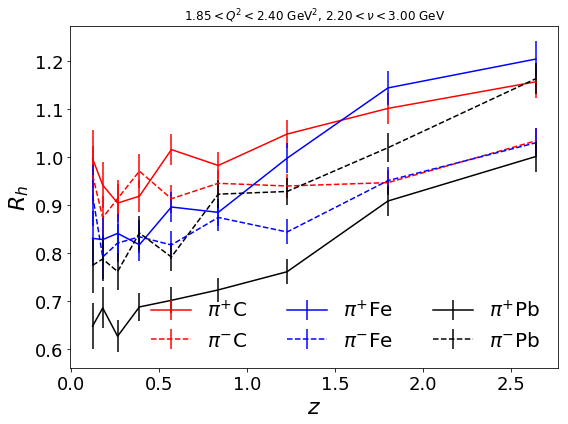

In [31]:
fig = plt.figure(figsize=(8,6))


colors = {}
colors['C'] = 'red'
colors['Fe'] = 'blue'
colors['Pb']= 'black'

minQ2 = 1.85
maxQ2 = 2.40
minNu = 2.2
maxNu = 3.0

event_selection = 'Q2>%2.2f and Q2<%2.2f and Nu>%2.2f and Nu<%2.2f'%(minQ2,maxQ2,minNu,maxNu)
print event_selection

for target in ['C','Fe','Pb']:
    r, err,x = getRatio(df['GiBUU_%s_hadron'%target].query('pid==211'), df['GiBUU_D_hadron'].query('pid==211'), 
                        df['GiBUU_%s_electron'%target], df['GiBUU_D_electron'], event_cut = event_selection,
                        minz=0.1,maxz=np.pi,nbins=10,variable='phi_pq')
    
    plt.errorbar(x,r,yerr=err,label=r'$\pi^{+}$'+'%s'%target,fmt='-',ms=8,color=colors[target])
    
    
    r, err,x = getRatio(df['GiBUU_%s_hadron'%target].query('pid==-211'), df['GiBUU_D_hadron'].query('pid==-211'), 
                        df['GiBUU_%s_electron'%target], df['GiBUU_D_electron'], event_cut = event_selection,
                        minz=0.1,maxz=np.pi,nbins=10,variable='phi_pq')
    
    plt.errorbar(x,r,yerr=err,label=r'$\pi^{-}$'+'%s'%target,fmt='-',ms=8,ls='--',color=colors[target])
    


plt.title(r'%2.2f$<Q^{2}<$%2.2f GeV$^{2}$, %2.2f$<\nu<$%2.2f GeV'%(minQ2,maxQ2,minNu,maxNu))
    
plt.xlabel('$z$',fontsize=22)
plt.ylabel('$R_{h}$',fontsize=22)
plt.legend(loc='best',ncol=3,frameon=False)
#plt.ylim([0.0,1.3])

plt.tight_layout()
plt.savefig('Rh.png')

In [ ]:
fig = plt.figure(figsize=(8,6))


colors = {}
colors['C'] = 'red'
colors['Fe'] = 'blue'
colors['Pb']= 'black'

minQ2 = 1.0
maxQ2 = 1.2


#event_selection = 'Q2>%2.2f and Q2<%2.2f and Nu>%2.2f and Nu<%2.2f'%(minQ2,maxQ2,minNu,maxNu)
event_selection = 'Q2>%2.2f and Q2<%2.2f'%(minQ2,maxQ2)

print event_selection

for target in ['C','Fe','Pb']:
    r_pip, err,x = getRatio(df['GiBUU_%s_hadron'%target].query('pid==211'), df['GiBUU_D_hadron'].query('pid==211'), 
                        df['GiBUU_%s_electron'%target], df['GiBUU_D_electron'], event_cut = event_selection,
                        minz=0.2,maxz=3.0,nbins=20,variable='P')
    
    plt.errorbar(x,r_pip,yerr=err,label=r'$\pi^{+}$'+'%s'%target,fmt='-',ms=8,color=colors[target])
    
    
    #r_pim, err,x = getRatio(df['GiBUU_%s_hadron'%target].query('pid==-211'), df['GiBUU_D_hadron'].query('pid==-211'), 
    #                    df['GiBUU_%s_electron'%target], df['GiBUU_D_electron'], event_cut = event_selection,
    #                    minz=0.2,maxz=3.0,nbins=20,variable='P')
    
    #plt.errorbar(x,r_pim,yerr=err,label=r'$\pi^{-}$'+'%s'%target,fmt='-',ms=8,ls='--',color=colors[target])
    
    ##print 'pi+', r_pip
    ##print 'pi-', r_pim
    #print np.true_divide(r_pip,r_pim)

plt.title(r'%2.2f$<Q^{2}<$%2.2f GeV$^{2}$'%(minQ2,maxQ2))
    
plt.xlabel('$P [GeV]$',fontsize=22)
plt.ylabel('$R_{h}$',fontsize=22)
plt.legend(loc='best',ncol=3,frameon=False)
plt.ylim([0.1,2.5])
#plt.xscale('log')
plt.tight_layout()
plt.savefig('Rh.png')

In [ ]:
fig = plt.figure(figsize=(8,6))


colors = {}
colors['C'] = 'red'
colors['Fe'] = 'blue'
colors['Pb']= 'black'

minQ2 = 1.0
maxQ2 = 1.2


#event_selection = 'Q2>%2.2f and Q2<%2.2f and Nu>%2.2f and Nu<%2.2f'%(minQ2,maxQ2,minNu,maxNu)
event_selection = 'Q2>%2.2f and Q2<%2.2f'%(minQ2,maxQ2)

print event_selection

for target in ['C','Fe','Pb']:
    r_pip, err,x = getRatio(df['GiBUU_%s_hadron'%target].query('pid==211'), df['GiBUU_D_hadron'].query('pid==211'), 
                        df['GiBUU_%s_electron'%target], df['GiBUU_D_electron'], event_cut = event_selection,
                        minz=0.2,maxz=3.0,nbins=20,variable='theta_lab')
    
    plt.errorbar(x,r_pip,yerr=err,label=r'$\pi^{+}$'+'%s'%target,fmt='-',ms=8,color=colors[target])
    
    
    #r_pim, err,x = getRatio(df['GiBUU_%s_hadron'%target].query('pid==-211'), df['GiBUU_D_hadron'].query('pid==-211'), 
    #                    df['GiBUU_%s_electron'%target], df['GiBUU_D_electron'], event_cut = event_selection,
    #                    minz=0.2,maxz=3.0,nbins=20,variable='P')
    
    #plt.errorbar(x,r_pim,yerr=err,label=r'$\pi^{-}$'+'%s'%target,fmt='-',ms=8,ls='--',color=colors[target])
    
    #print 'pi+', r_pip
    #print 'pi-', r_pim
   # print np.true_divide(r_pip,r_pim)

plt.title(r'%2.2f$<Q^{2}<$%2.2f GeV$^{2}$'%(minQ2,maxQ2))
    
plt.xlabel('$\theta rad$',fontsize=22)
plt.ylabel('$R_{h}$',fontsize=22)
plt.legend(loc='best',ncol=3,frameon=False)
plt.ylim([0.1,2.5])
#plt.xscale('log')
plt.tight_layout()
plt.savefig('Rh.png')

In [ ]:
fig = plt.figure(figsize=(8,6))


colors = {}
colors['C'] = 'red'
colors['Fe'] = 'blue'
colors['Pb']= 'black'

minQ2 = 1.85
maxQ2 = 2.40
minNu = 2.2
maxNu = 3.0

#event_selection = 'Q2>%2.2f and Q2<%2.2f and Nu>%2.2f and Nu<%2.2f'%(minQ2,maxQ2,minNu,maxNu)
event_selection = 'Q2>%2.2f and Q2<%2.2f'%(minQ2,maxQ2)

print event_selection



plt.vlines(0.2, 0,3.0,color='red')

#plt.xscale('log')
plt.hist(df['GiBUU_D_hadron'].query('pid==211 and P>0.2')['T'],bins=50,alpha=0.3,normed=2.0)
for target in ['D','C','Fe','Pb']:
    plt.hist(df['GiBUU_%s_hadron'%target].query('pid==211 and P>0.2')['T'],histtype='step',bins=50,alpha=0.8,normed=2.0)

In [ ]:
fig = plt.figure(figsize=(8,6))


colors = {}
colors['C'] = 'red'
colors['Fe'] = 'blue'
colors['Pb']= 'black'

minQ2 = 1.85
maxQ2 = 2.40
minNu = 2.2
maxNu = 3.0

#event_selection = 'Q2>%2.2f and Q2<%2.2f and Nu>%2.2f and Nu<%2.2f'%(minQ2,maxQ2,minNu,maxNu)
event_selection = 'Q2>%2.2f and Q2<%2.2f'%(minQ2,maxQ2)

print event_selection

plt.hist(df['GiBUU_D_hadron'].query('pid==211')['theta_lab'],bins=20,alpha=0.3,normed=2.0)
for target in ['D','C','Fe','Pb']:
    plt.hist(df['GiBUU_%s_hadron'%target].query('pid==211')['theta_lab'],histtype='step',bins=20,alpha=0.3,normed=2.0)

## Result compared with GiBUU

In [ ]:
plt.hexbin(df_trigger['D_trigger']['Q2'],df_trigger['D_trigger']['Nu'], cmap='inferno')


In [ ]:
plt.hexbin(df_trigger['GiBUU_D_trigger']['Q2'],df_trigger['GiBUU_D_trigger']['Nu'],cmap='inferno')
